### For this project, we require two files viz, reviews.csv and tokenization file. We will use gdown to import both the files in Google Colab from Google drive.

In [ ]:
!gdown --id 1GsD8JlAc_0yJ-1151LNr6rLw83RRUPgt
!gdown --id 13exfXiyiByluh1PfYK1EyZyizqxeCVG9

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1GsD8JlAc_0yJ-1151LNr6rLw83RRUPgt
To: /content/Reviews.csv
100% 301M/301M [00:03<00:00, 76.4MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=13exfXiyiByluh1PfYK1EyZyizqxeCVG9
To: /content/tokenization.py
100% 17.3k/17.3k [00:00<00:00, 26.9MB/s]


### Importing the necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import re
import os

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from keras.wrappers.scikit_learn import KerasClassifier

from tqdm import *


In [ ]:
import datetime

!rm -rf ./logs/*
LOG_DIR = './logs'

## 1. Preprocessing the text reviews of the Amazon Fine Food Reviews Dataset.

In [ ]:
reviews = pd.read_csv(r'Reviews.csv')
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


#### Out of the 10 columns of the Amazon Fine Food Reviews dataset, we only require two columns which are the Text column and the Score column. Here Text column contains the actual review given the users and the Score column contains the actual rating given by the users. We will also drop the NaN values from our dataset.

In [ ]:
reviews=reviews[['Text','Score']]
reviews.dropna(axis=0)

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5
...,...,...
568449,Great for sesame chicken..this is a good if no...,5
568450,I'm disappointed with the flavor. The chocolat...,2
568451,"These stars are small, so you can give 10-15 o...",5
568452,These are the BEST treats for training and rew...,5


In [ ]:
reviews.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


#### In this project, we are trying to perform sentiment analysis which means that we are trying to classify whether a review is positive or negative. The Score column in the dataset contains the actual rating given by a user to a particular product. The rating is  out of 5. If the rating for any product is less than 3, we can assume that there is a high possibility that the rating for that product will be negative.  If the rating for any product is more than 3, we can assume that there is a high possibility that the rating for that product will be positive. A rating of 3 could mean a neutral review, neither positive nor negative. So if the Score is more than 3, we will replace it by 1 which means that the review is positive. If the Score is less than 3, we will replace it by 0 which means that the review is negative. If any row contains a Score of 3, we will remove that row from our dataset. 

In [ ]:
remove_third_row = []
for ele, m in tqdm_notebook(reviews.iterrows()):
    if m['Score'] > 3:
       reviews.at[ele,'Score'] = 1
    if m['Score'] < 3:
       reviews.at[ele,'Score'] = 0
    if m['Score'] == 3:
       remove_third_row.append(ele)

reviews = reviews.drop(remove_third_row)
reviews

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


0it [00:00, ?it/s]

,Text,Score
0,I have bought several of the Vitality canned d...,1
1,Product arrived labeled as Jumbo Salted Peanut...,0
2,This is a confection that has been around a fe...,1
3,If you are looking for the secret ingredient i...,0
4,Great taffy at a great price. There was a wid...,1
...,...,...
568449,Great for sesame chicken..this is a good if no...,1
568450,I'm disappointed with the flavor. The chocolat...,0
568451,"These stars are small, so you can give 10-15 o...",1
568452,These are the BEST treats for training and rew...,1


In [ ]:
def get_wordlen(x):
    return len(x.split())

reviews['len'] = reviews.Text.apply(get_wordlen)
reviews = reviews[reviews.len<50]
reviews = reviews.sample(n=100000, random_state=30)

#### We will now remove the HTML tags from the Text column in the dataset and store them in the Text column only.

In [ ]:
for ele, m in tqdm_notebook(reviews.iterrows()):
   f = re.sub("<.*>", ' ',str(m['Text']))
   reviews.at[ele,'Text'] = f

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


0it [00:00, ?it/s]

In [ ]:
reviews.head(5)

,Text,Score,len
64117,The tea was of great quality and it tasted lik...,1,30
418112,My cat loves this. The pellets are nice and s...,1,31
357829,Great product. Does not completely get rid of ...,1,41
175872,This gum is my favorite! I would advise every...,1,27
178716,I also found out about this product because of...,1,22


#### We will now perform the train-test split. We will perform stratified sampling. 

In [ ]:
X = reviews.drop('Score', axis=1) 
y = reviews['Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=33)

#### Let us now look at the number of positive and negative reviews in the train and test datasets.

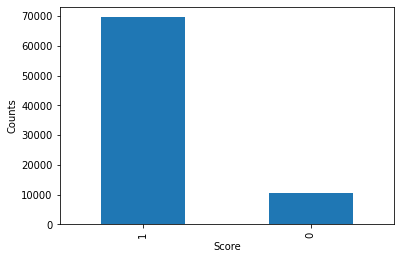

In [ ]:
y_train.value_counts().plot(kind='bar', xlabel='Score', ylabel='Counts')

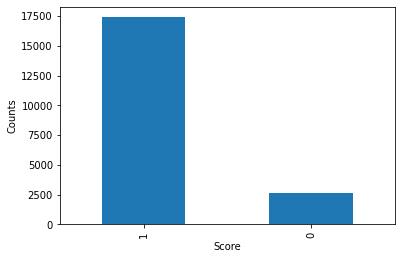

In [ ]:
y_test.value_counts().plot(kind='bar',xlabel='Score', ylabel='Counts')

## 2. Load a pre-trained BERT model from TensorFlow Hub
#### We will be using the pre-trained BERT uncased model. It uses 12 hidden layers or transformer blocks, a hidden size of 768 and 12 attention heads. 

In [ ]:
tf.keras.backend.clear_session()

max_seq_length = 55

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)


In [ ]:
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 55)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 55)]         0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 55)]         0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 55, 768)]                 'input_mask[0][0]',         

In [ ]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

## 3. Perform Tokenization
#### Here we will convert the text to a sequence of integers.

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 9.7 MB/s 


In [ ]:
import tokenization

tokenizer=tokenization.FullTokenizer(vocab_file,do_lower_case )

In [ ]:
max_no_of_tokens = 55
X_train_tokens=[]
X_train_mask = []
X_train_segment = []

In [ ]:
for ele in tqdm_notebook(range(len(X_train))):
    tk=tokenizer.tokenize(X_train.values[ele][0])
    if len(tk)>= max_no_of_tokens-2:
       tk = tk[0:(max_no_of_tokens-2)]

    tk = ['[CLS]',*tk,'[SEP]']
    pd = max_no_of_tokens - len(tk)
    if pd > 0 :
      ps = ['[PAD]']*pd
      tk_final = [*tk,*ps]
    else:
      tk_final = tk
    t = np.array(tokenizer.convert_tokens_to_ids(tk_final))
    m_t = np.array([1]*len(tk)+[0]*pd)
    s_t = np.array([0]*len(tk_final))

    X_train_tokens.append(t)
    X_train_mask.append(m_t)
    X_train_segment.append(s_t)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


  0%|          | 0/80000 [00:00<?, ?it/s]

In [ ]:
X_train_tokens = np.asarray(X_train_tokens)
print(X_train_tokens.shape)

(80000, 55)


In [ ]:
X_train_mask = np.asarray(X_train_mask)
print(X_train_mask.shape)

(80000, 55)


In [ ]:
X_train_segment = np.asarray(X_train_segment)
print(X_train_segment.shape)

(80000, 55)


In [ ]:
max_no_of_tokens = 55
X_test_tokens=[]
X_test_mask = []
X_test_segment = []

In [ ]:
for ele in tqdm_notebook(range(len(X_test))):
    tk=tokenizer.tokenize(X_test.values[ele][0])
    if len(tk)>= max_no_of_tokens-2:
       tk = tk[0:(max_no_of_tokens-2)]

    tk = ['[CLS]',*tk,'[SEP]']
    pd = max_no_of_tokens - len(tk)
    if pd > 0 :
      ps = ['[PAD]']*pd
      tk_final = [*tk,*ps]
    else:
      tk_final = tk
    t = np.array(tokenizer.convert_tokens_to_ids(tk_final))
    m_t = np.array([1]*len(tk)+[0]*pd)
    s_t = np.array([0]*len(tk_final))

    X_test_tokens.append(t)
    X_test_mask.append(m_t)
    X_test_segment.append(s_t)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


  0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
X_test_tokens = np.asarray(X_test_tokens)
print(X_test_tokens.shape)

(20000, 55)


In [ ]:
X_test_mask = np.asarray(X_test_mask)
print(X_test_mask.shape)

(20000, 55)


In [ ]:
X_test_segment = np.asarray(X_test_segment)
print(X_test_segment.shape)

(20000, 55)


## 4. For each review in the train and the test dataset, we will get the embedding vector from the pre-trained BERT model.

In [ ]:
bert_model.input

[<KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_word_ids')>,
 <KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_mask')>,
 <KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'segment_ids')>]

In [ ]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

In [ ]:
X_train_pooled_output=bert_model.predict([X_train_tokens,X_train_mask,X_train_segment])

In [ ]:
X_test_pooled_output=bert_model.predict([X_test_tokens,X_test_mask,X_test_segment])

## 5. We will now train a Neural Network model on top of the output obtained from the pre-trained BERT model . We will be using AUC as a metric to evaluate our model's performance.

In [ ]:
score_train = to_categorical(y_train)
score_test = to_categorical(y_test)

In [ ]:
#Reference: https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

def select_optimal_hyperparameters(list_activation,list_lr):
     
     os.environ['PYTHONHASHSEED'] = '0'
     tf.keras.backend.clear_session()

     input_layer = tf.keras.layers.Input(shape=(X_train_pooled_output.shape[1],))
 
     dense_1 = tf.keras.layers.Dense(64,activation=list_activation,kernel_initializer=tf.keras.initializers.RandomNormal(seed=25),name = 'dense_1')(input_layer)
     dense_2 = tf.keras.layers.Dense(64,activation=list_activation,kernel_initializer=tf.keras.initializers.RandomNormal(seed=25),name = 'dense_2')(dense_1)
     dense_3 = tf.keras.layers.Dense(64,activation=list_activation,kernel_initializer=tf.keras.initializers.RandomNormal(seed=25),name = 'dense_3')(dense_2)
     dense_4 = tf.keras.layers.Dense(64,activation=list_activation,kernel_initializer=tf.keras.initializers.RandomNormal(seed=25),name = 'dense_4')(dense_3)

     output_layer = tf.keras.layers.Dense(2,activation='softmax',kernel_initializer=tf.keras.initializers.RandomNormal(seed=24),name = "output_layer")(dense_4)

     final_model = tf.keras.models.Model(inputs=input_layer,outputs=output_layer)

     final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=list_lr),loss='binary_crossentropy',metrics=['AUC','accuracy'])
   
     return final_model

In [ ]:
# Grid Search over the following parameters
list_activation = ['sigmoid','relu']
list_lr = [0.01,0.0001]

In [ ]:
# All parameters added to a dictionary
param_grid = dict(list_activation=list_activation,list_lr=list_lr)

In [ ]:
model = KerasClassifier(build_fn=select_optimal_hyperparameters, epochs=5, batch_size=10, verbose=1)
param_grid = dict(list_activation=list_activation,list_lr=list_lr)

gs = GridSearchCV(estimator=model, param_grid=param_grid)
search_res = gs.fit(X_train_pooled_output, score_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


Epoch 1/5
6400/6400 [==============================] - 26s 4ms/step - loss: 0.3908 - auc: 0.8717 - accuracy: 0.8709
Epoch 2/5
6400/6400 [==============================] - 24s 4ms/step - loss: 0.3907 - auc: 0.8679 - accuracy: 0.8709
Epoch 3/5
6400/6400 [==============================] - 24s 4ms/step - loss: 0.3904 - auc: 0.8713 - accuracy: 0.8709
Epoch 4/5
6400/6400 [==============================] - 24s 4ms/step - loss: 0.3905 - auc: 0.8712 - accuracy: 0.8709
Epoch 5/5
1600/1600 [==============================] - 5s 3ms/step - loss: 0.3926 - auc: 0.8667 - accuracy: 0.8667
Epoch 1/5
6400/6400 [==============================] - 25s 4ms/step - loss: 0.3910 - auc: 0.8694 - accuracy: 0.8700
Epoch 2/5
6400/6400 [==============================] - 24s 4ms/step - loss: 0.3905 - auc: 0.8692 - accuracy: 0.8700
Epoch 3/5
6400/6400 [==============================] - 24s 4ms/step - loss: 0.3901 - auc: 0.8702 - accuracy: 0.8700
Epoch 4/5
6400/6400 [==============================] - 24s 4ms/step - los

In [ ]:
print(search_res.best_score_)
print(search_res.best_params_)

0.9188874959945679
{'list_activation': 'relu', 'list_lr': 0.0001}


In [ ]:
##https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

# Model with best hyperparameters Activation : relu and learning rate : 0.0001

os.environ['PYTHONHASHSEED'] = '0'
tf.keras.backend.clear_session()

input_layer = tf.keras.layers.Input(shape=(X_train_pooled_output.shape[1],))

dense_1 = tf.keras.layers.Dense(64,activation='relu',kernel_initializer=tf.keras.initializers.RandomNormal(seed=25),name = 'dense_1')(input_layer)
dense_2 = tf.keras.layers.Dense(64,activation='relu',kernel_initializer=tf.keras.initializers.RandomNormal(seed=25),name = 'dense_2')(dense_1)
dense_3 = tf.keras.layers.Dense(64,activation='relu',kernel_initializer=tf.keras.initializers.RandomNormal(seed=25),name = 'dense_3')(dense_2)
dense_4 = tf.keras.layers.Dense(64,activation='relu',kernel_initializer=tf.keras.initializers.RandomNormal(seed=25),name = 'dense_4')(dense_3)

output_layer = tf.keras.layers.Dense(2,activation='softmax',kernel_initializer=tf.keras.initializers.RandomNormal(seed=30),name = 'output_layer')(dense_4)

final_model_1 = tf.keras.models.Model(inputs=input_layer,outputs=output_layer)

final_model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 768)]             0         
                                                                 
 dense_1 (Dense)             (None, 64)                49216     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 output_layer (Dense)        (None, 2)                 130       
                                                                 
Total params: 61,826
Trainable params: 61,826
Non-trainable p

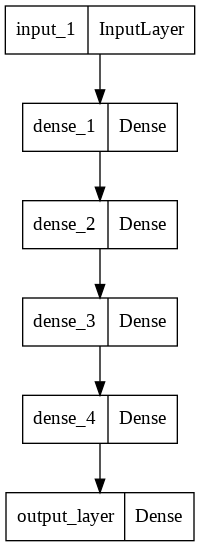

In [ ]:
plot_model(final_model_1)

In [ ]:
final_model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['AUC','accuracy'])

In [ ]:
final_model_1.fit(X_train_pooled_output, score_train, batch_size=10, epochs=10, validation_data=(X_test_pooled_output,score_test))

Epoch 1/10
8000/8000 [==============================] - 35s 4ms/step - loss: 0.2836 - auc: 0.9492 - accuracy: 0.8887 - val_loss: 0.2155 - val_auc: 0.9707 - val_accuracy: 0.9074
Epoch 2/10
8000/8000 [==============================] - 34s 4ms/step - loss: 0.2036 - auc: 0.9709 - accuracy: 0.9153 - val_loss: 0.1958 - val_auc: 0.9711 - val_accuracy: 0.9194
Epoch 3/10
8000/8000 [==============================] - 34s 4ms/step - loss: 0.1942 - auc: 0.9729 - accuracy: 0.9209 - val_loss: 0.1863 - val_auc: 0.9761 - val_accuracy: 0.9243
Epoch 4/10
8000/8000 [==============================] - 34s 4ms/step - loss: 0.1884 - auc: 0.9746 - accuracy: 0.9236 - val_loss: 0.1867 - val_auc: 0.9752 - val_accuracy: 0.9248
Epoch 5/10
8000/8000 [==============================] - 34s 4ms/step - loss: 0.1855 - auc: 0.9752 - accuracy: 0.9242 - val_loss: 0.1944 - val_auc: 0.9702 - val_accuracy: 0.9205
Epoch 6/10
8000/8000 [==============================] - 34s 4ms/step - loss: 0.1830 - auc: 0.9756 - accuracy: 0.925

## 6. Observations

#### 1.   We observe that the data is highly unbalanced due to which we obtain a high accuracy and a large AUC from the very beginning.
#### 2.   A large number of datapoints have class label 1. As a result, the best hyperparameter value (learning rate) is very small i.e. 0.0001
#### 3.   If we want to make any significant improvement, the learning rate must be kept lower. This will help us to make correct predictions.